In [1]:
%matplotlib notebook

from matplotlib.pyplot import imshow
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

from keras.models import load_model

/home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [14]:
K.set_learning_phase(0) # 0 for test. Some layers (such as batch normalisation will work only after doing this)

# model = vgg16.VGG16(weights='imagenet', include_top=True)
model = load_model('cnn_100epoch_adam.h5')
print('Model loaded.')

input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

Model loaded.


In [4]:
layer_dict

{'batch_normalization_2': <keras.layers.normalization.BatchNormalization at 0x2ab743ee1d30>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x2ab743ee1588>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x2ab743ee1a90>,
 'dense_3': <keras.layers.core.Dense at 0x2ab743ee1da0>,
 'dense_4': <keras.layers.core.Dense at 0x2ab743ef4048>,
 'dropout_5': <keras.layers.core.Dropout at 0x2ab743ee17f0>,
 'dropout_6': <keras.layers.core.Dropout at 0x2ab743ee1c18>,
 'flatten_2': <keras.layers.core.Flatten at 0x2ab743ee1cf8>,
 'max_pooling2d_5': <keras.layers.pooling.MaxPooling2D at 0x2ab743ee16d8>,
 'max_pooling2d_6': <keras.layers.pooling.MaxPooling2D at 0x2ab743ee1ac8>}

In [8]:
img_width = 41
img_height = 41

# the name of the layer we want to visualize
# (see model definition at https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py#L115)

layer_name = 'block3_conv1'
channels = 1 # Use 3 for RBG, 1 for grayscale
output_layer = False

In [9]:
layer_dict[layer_name].output  # (_, _, _, numFilters). numFilters gives the number of filters available at this layer

<tf.Tensor 'block3_conv1/Relu:0' shape=(?, 20, 20, 64) dtype=float32>

In [15]:
kept_filters = []
for filter_index in range(64):
    # we only scan through the first 32 filters but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    
    if output_layer:
        loss = K.mean(model.output[:, 18])
    else:
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])


    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, channels, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, channels))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        print(i)
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

#         print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
0
Filter 0 processed in 0s
Processing filter 1
0
Filter 1 processed in 0s
Processing filter 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Filter 2 processed in 0s
Processing filter 3
0
Filter 3 processed in 0s
Processing filter 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Filter 4 processed in 0s
Processing filter 5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Filter 5 processed in 0s
Processing filter 6
0
Filter 6 processed in 0s
Processing filter 7
0
Filter 7 processed in 0s
Processing filter 8
0
Filter 8 processed in 0s
Processing filter 9
0
Filter 9 processed in 0s
Processing filter 10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Filter 10 processed in 0s
Processing filter 11
0
Filter 11 processed in 0s
Processing filter 12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Filter 12 processed in 0s
Processing filter 13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Filter 13 processed in 0s
Processing filter 14
0
1
2
3
4
5
6
7
8
9
10
11

<IPython.core.display.Javascript object>


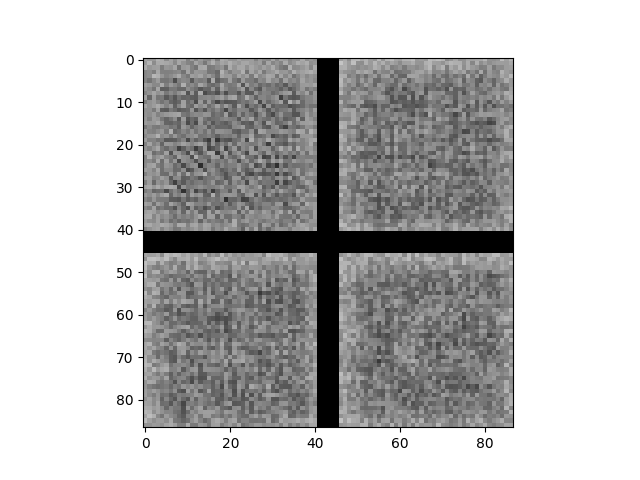

In [18]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 2

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters_top = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters_top[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
# imshow('stitched_filters_%dx%d.png' % (n, n), stitched_filters)
imshow(stitched_filters)